# Multiclass Classification for Risk Analysis

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pickle 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
import xgboost
import matplotlib.pyplot as plt
import shap 
from util import * 

## Section 1: Data Preprocessing

To start, Let's load the data collected from Natioanl Transportation Safety board. In this analysis, we want to categorize the damage level of the accident given the event sequence. 

In [2]:
mypath = "data/NTSB"
data_group = pd.read_pickle("data/data_group.pkl") 
occurrence_code_corpus = np.load("data/occurrence_code_corpus.npy")
subject_code_corpus = np.load("data/subject_code_corpus.npy")
phase_code_corpus = np.load("data/phase_code_corpus.npy")
data_map = {"Phase_of_Flight":phase_code_corpus,"Occurrence_Code": occurrence_code_corpus, "Subj_Code":subject_code_corpus}
DataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')

Next we will split the data into train/validation/test set.

In [3]:
# Train test split
nsamples = len(data_group)
np.random.seed(0)
train_idx = np.random.choice(nsamples,int(nsamples*0.8),replace=False)
test_val_idx= np.setdiff1d(np.arange(nsamples),train_idx)
val_idx = np.random.choice(test_val_idx,int(nsamples*0.01),replace=False) 
test_idx =  np.setdiff1d(test_val_idx,val_idx)
len(train_idx), len(test_idx)

(48858, 11605)

The codes in this manual are intended to be used to describe the sequence-of-events of each accident and/or incident. All entries in the sequence-of events (and brief narrative) must be substantiated by information that is documented in the Factual Report or is available in other accessible documents or publications. Multiple occurrences, causes, factors and/or events may be used in each sequence-of-events to describe the findings. Each occurrence is coded separately and a corresponding phase of operation must be entered with each occurrence; as of the date of this publication, only five occurrences can be recorded for each mishap. There must be at least one occurrence and one cause identified with each accident or incident. The occurrences must be chronologically numbered. For accidents with multiple causes, there is no provision to show the magnitude of each cause with respect to the others. Likewise, there is no provision to show the relative magnitude of multiple factors.

In [4]:
data_group.head(2)

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Subj_Code,damage,ev_highest_injury
0,20001204X00000,1,"[1, 1, 1, 3, 3]","[0, 40, 40, 40, 27, 27, 1]","[0, 20, 20, 20, 34, 34, 1]","[0, 912, 865, 438, 620, 703, 1]",1,MINR
1,20001204X00001,1,"[1, 1, 1, 1, 1, 2]","[0, 3, 3, 3, 3, 3, 19, 1]","[0, 32, 32, 32, 32, 32, 3, 1]","[0, 1239, 1316, 63, 692, 692, 1013, 1]",0,NONE


In [5]:
key = "Occurrence_Code"
idx = 0 
for key in data_map:
    print(key)
    for i in set(data_group.loc[idx, key][1:-1]):
        print(i, DataDict[(DataDict['Column']==key)&(DataDict['code_iaids']==data_map[key][i])]["meaning"].to_list()[0])
    print("------------------")

Phase_of_Flight
34 Emergency landing
20 Approach
------------------
Occurrence_Code
40 Loss of engine power
27 On ground/water collision with terrain/water
------------------
Subj_Code
865 Improper use of procedure
620 Terrain condition
912 Engine assembly, crankshaft
438 Inadequate quality control
703 Object
------------------


Next, we will generate the event-based features for the classification model. The features are converted from discrete event representation into one hot encoding representation. The dimension of phase, occurrence and subject are 56, 58 and 1432. We will use an array initialized with all zeros for three events level. And then fill in 1s for each zero vector according to which event happens in that accident. 
Finally, for each accident, we construct a feature vector with dimension of 1546

In [6]:
data_subject = [list(set(x)) for x in data_group['Subj_Code']]
data_occurrence = [list(set(x)) for x in data_group['Occurrence_Code']]
data_phase = [list(set(x)) for x in data_group['Phase_of_Flight']]
data_damge = np.array(list(data_group['damage']))

data_total = []
for i in range(len(data_subject)):
    subject_buffer = np.zeros(len(subject_code_corpus))
    phase_buffer = np.zeros(len(phase_code_corpus))
    occurrence_buffer = np.zeros(len(occurrence_code_corpus))
    for j in data_subject[i]:
        subject_buffer[j] = 1
    for j in data_occurrence[i]:
        occurrence_buffer[j] = 1
    for j in data_phase[i]:
        phase_buffer[j] = 1
    a = np.concatenate((subject_buffer,occurrence_buffer, phase_buffer),axis=0)
    data_total.append(a)
data_total = np.array(data_total)

## Section 2: Modeling

Next, we will start the modeling process. We will leverage random crocess validation to achieve hyperparameter tuning to find the best set of parameters for the random forest classifier. Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values. We will try adjusting the following set of hyperparameters:
- bootstrap = method for sampling data points (with or without replacement)
- max_depth = max number of levels in each decision tree
- max_features = max number of features considered for splitting a node
- min_samples_leaf = min number of data points allowed in a leaf node
- min_samples_split = min number of data points placed in a node before the node is split
- n_estimators = number of trees in the foreset
On each iteration, the algorithm will choose a difference combination of the features. The benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [7]:
%%time
model = RandomForestClassifier()
parameters = {
            'bootstrap': [True, False],
             'max_depth': [10, 50, 100],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 4],
             'min_samples_split': [2, 10],
             'n_estimators': [10, 100]
             }
random_cv_rf = RandomizedSearchCV(estimator=model,
                           param_distributions=parameters,
                           cv=4, n_iter=25, 
                           n_jobs = -1, verbose = 1, 
                           return_train_score = True,
                           random_state=42)
random_cv_rf.fit(data_total[train_idx],data_damge[train_idx])
print(random_cv_rf.best_params_)
print (f'Train Accuracy - : {random_cv_rf.score(data_total[train_idx],data_damge[train_idx]):.3f}')
print (f'Test Accuracy - : {random_cv_rf.score(data_total[test_idx],data_damge[test_idx]):.3f}')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
Train Accuracy - : 0.885
Test Accuracy - : 0.809
CPU times: user 54.1 s, sys: 725 ms, total: 54.9 s
Wall time: 6min 14s


## Section 3: Result Analysis

In this section, we will start evaluating the model performance from other perspectives such as reliability and shap value. 

## Reliability Diagram

In [8]:
a = data_damge[test_idx]
labels_oneh = np.zeros((a.size, a.max()+1))
labels_oneh[np.arange(a.size),a] = 1
preds = random_cv_rf.predict_proba(data_total[test_idx])
preds = preds.flatten()
labels_oneh = labels_oneh.flatten()

We can visualize how well the predicted confidence scores hold up against their actual accuracy through reliability diagram. As we can see from the plot, all the confidence scores of the are binned into M=10 distinct bins [0, 0.1), [0.1, 0.2),…, [0.9, 1]. 

For each bin we can then calculate its accuracy and confidence. We want the most confident prediction with highest accuracy. Thus, the 45 degree diagnol line shows the calibrated uncertainty.

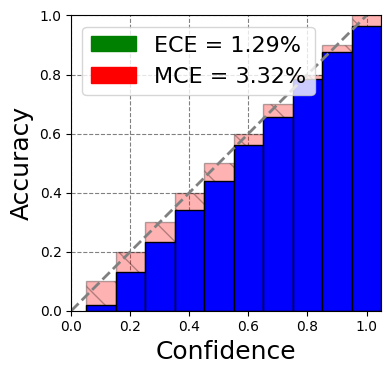

In [9]:
draw_reliability_graph(preds, labels_oneh)

## Shap Value

In [14]:
%%time
import shap
model = random_cv_rf.best_estimator_
shap_values = shap.TreeExplainer(model).shap_values(data_total[train_idx], approximate=True) 

CPU times: user 5.23 s, sys: 865 ms, total: 6.09 s
Wall time: 6.08 s


In [15]:
feature_list = subject_code_corpus.tolist() + occurrence_code_corpus.tolist()+ phase_code_corpus.tolist()

feature_list_meaning = []
for x in feature_list:
    if x == '000':
        feature_list_meaning.append('start')
    elif x == '999':
        feature_list_meaning.append('end')
    elif len(DataDict[DataDict['code_iaids']==x]['meaning'])==0:
        feature_list_meaning.append('unknown')
    else:
        meaning = list(DataDict[DataDict['code_iaids']==x]['meaning'])[0]
        feature_list_meaning.append(meaning)

SHapley Additive exPlanations will help us further understand how each individual feature contribute to the results. Following figure plot the feature importance calculated by the Shaypley value. We only shown the most important 19 events. From the figure, we can see that different color represent the event’s importance in corresponding risk level. And we further ranked event importance according to the summation over different risk levels which can be viewed as global importance. We can see that Landing - roll is the most important event globally speaking. It is the most important indicator for the minor accidents.

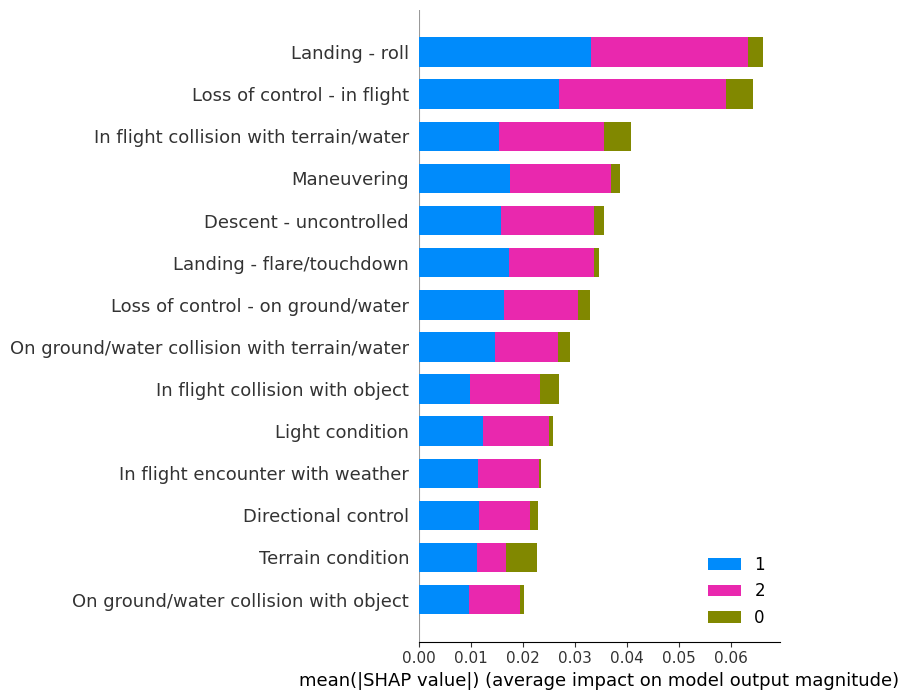

In [18]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, data_total[train_idx], feature_names=feature_list_meaning, plot_type="bar",max_display=14, class_names=model.classes_,show=False)

We further show the event effects in different risk levels. From following figure, we show the event effects on the destroyed accident. In this plot, each point represent the Shapley value for the event in an accident. Y-axis is the list of events and X-axis means the Shapley value. From the plot, we can see the distribution of the Shapley values for each event. For example, we can see most of the accidents that include Landing - flare/touchdown have high Shapley value. It shows that Landing - flare/touchdown is a good indicator that the accident is low risk.

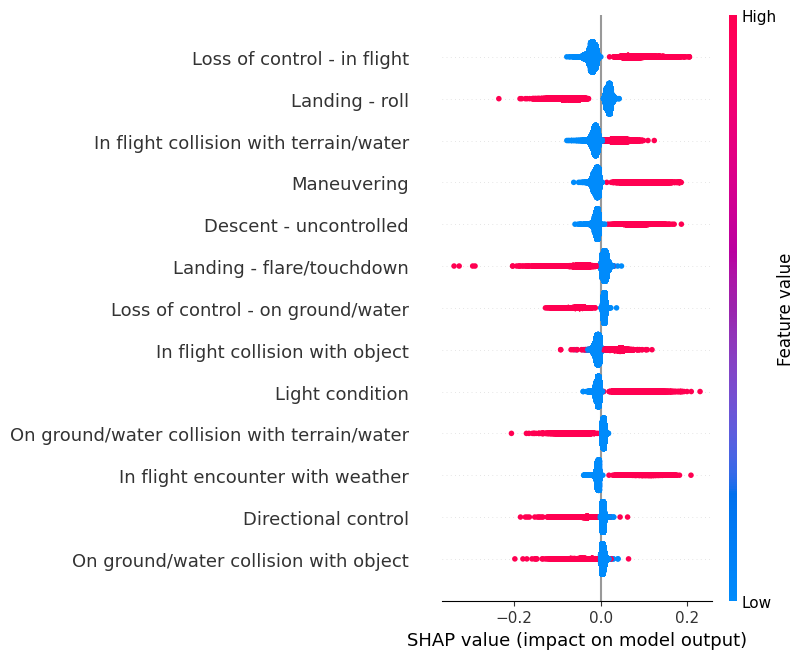

In [23]:
shap.summary_plot(shap_values[2], data_total[train_idx], feature_names=feature_list_meaning,max_display=13,show=False)